Imports

In [293]:
from matplotlib.lines import Line2D
from matplotlib.path import Path
from matplotlib.patches import PathPatch
import matplotlib.pyplot as plt
import networkx as nx
from pyproj import Transformer
import shapely
import shapely.ops

import math
import json

Local functions

In [294]:
def plot_linestrings(linestrings: list[shapely.LineString]):
    if isinstance(linestrings, shapely.LineString):
        multilinestring = shapely.MultiLineString([linestrings])
    else:
        multilinestring = linestrings
    
    lines = []
    for linestring in multilinestring.geoms:
        xs = []
        ys = []
        for coord in linestring.coords:
            xs.append(coord[0])
            ys.append(coord[1])
        lines.append(Line2D(xs, ys))
    fig, ax = plt.subplots()
    for line in lines:
        ax.add_line(line)
    ax.axis("equal")
    plt.show()

def plot_polygons(polygons: list[shapely.Polygon]):
    pathpatches = []
    for polygon in polygons:
        vertices = list(polygon.exterior.coords)
        codes = [Path.MOVETO] + [Path.LINETO] * (len(polygon.exterior.coords) - 2) + [Path.CLOSEPOLY]
        for interior in polygon.interiors:
            vertices += list(interior.coords)
            codes += [Path.MOVETO for i in range(min(len(interior.coords), 1))] + [Path.LINETO for i in range(len(interior.coords[1:-1]))] + [Path.CLOSEPOLY]
        path = Path(vertices, codes=codes)
        pathpatches.append(PathPatch(path))
    fig, ax = plt.subplots()
    for pathpatch in pathpatches:
        ax.add_patch(pathpatch)
    ax.axis("equal")
    plt.show()

def distance(p1, p2):
    return math.sqrt((p1[0] - p2[0]) * (p1[0] - p2[0]) + (p1[1] - p2[1]) * (p1[1] - p2[1]))

**Step 1**  
Importing and parsing a building footprint from a ```.geojson``` polygon.  
[```EvertonPark7.geojson```](./EvertonPark7.geojson) is the example described in the documentation, while [```TanjongPagarPlaza.geojson```](./TanjongPagarPlaza.geojson) is an additional test case using a polygon with holes.  
All polygons are assumed to be using EPSG:4326 / WGS84 and they are first converted to EPSG:3414 / SVY21.

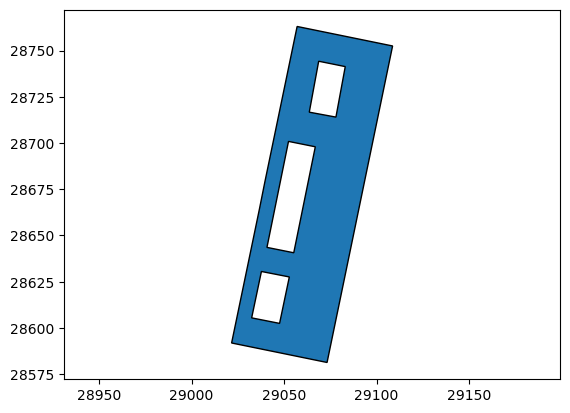

In [295]:
with open("./TanjongPagarPlaza.geojson", 'r') as fp:
    geojson = json.load(fp)

transformer = Transformer.from_crs(crs_from=4326, crs_to=3414, always_xy=True)
shell = transformer.itransform(geojson["geometry"]["coordinates"][0])
holes = [transformer.itransform(hole) for hole in geojson["geometry"]["coordinates"][1:]]

footprint = shapely.Polygon(shell=shell, holes=holes)
plot_polygons([footprint])

**Steps 2 to 5**  
Buffers ```footprint``` polygon by 0.5m using ```shapely.buffer```. Because shapely does not implement smooth curves, ```quad_segs``` is set to 8 to ensure that the maximum angle between line segments is 10°. The maximum deviation of the linear spline approximation is assumed to be within 0.1m of the intended smooth buffer curve.

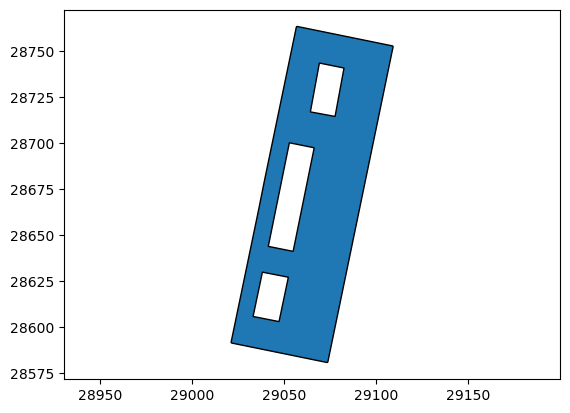

In [296]:
buffer = shapely.buffer(footprint, 0.5, quad_segs=8, cap_style="round")
densified = shapely.segmentize(buffer, 1)
plot_polygons([buffer])

**Step 6**

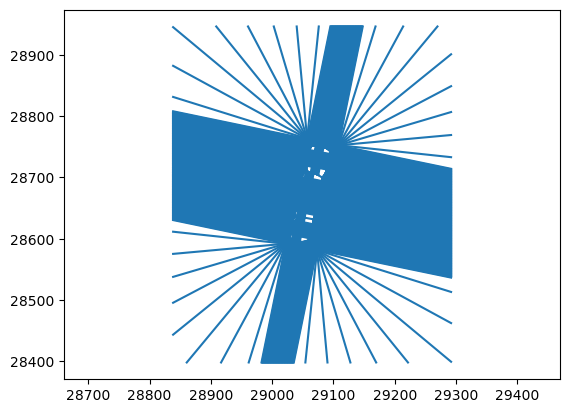

In [297]:
voronoi = shapely.voronoi_polygons(densified, only_edges=True)
plot_linestrings(voronoi)

**Steps 7 to 13**  
Functionally performs the steps, but order of operations are changed to utilise shapely's built in functions.

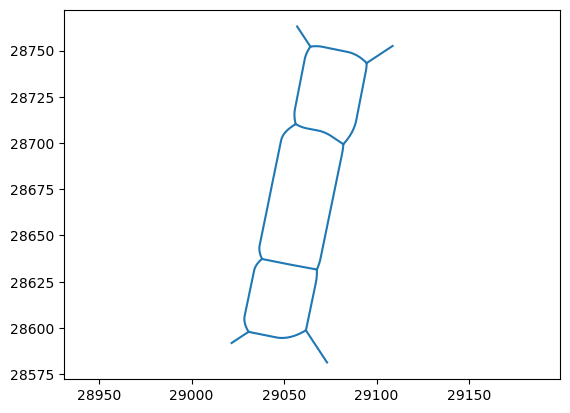

In [298]:
skeleton = []
for linestring in voronoi.geoms:
    if not (shapely.intersects(linestring, buffer.exterior) or shapely.intersects(linestring, shapely.MultiLineString(buffer.interiors))):
        skeleton.append(linestring)
skeleton = shapely.MultiLineString(skeleton)
skeleton_clipped = shapely.intersection(skeleton, buffer)
skeleton_merged = shapely.ops.linemerge(skeleton_clipped)
plot_linestrings(skeleton_merged)

**Step 14**    
I am 60% sure I am writing the iterative removal of "end" polylines shorter than 5m correctly, but I suspect that the "cleanliness" of the graph due to precision issues and very short segments are making this iterative removal behave unexpectedly.  
As an aside, I feel that the clipped voronoi/thiessen output from step 13 is already sufficient for representing the internal building paths.

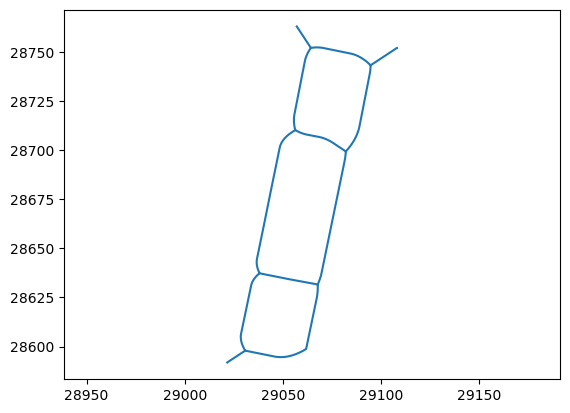

In [299]:
G = nx.Graph()
points = {}
i = 0
for linestring in skeleton_merged.geoms:
    for j in range(1, len(linestring.coords)):
        if not linestring.coords[j - 1] in points:
            G.add_node(i, x=linestring.coords[j - 1][0], y=linestring.coords[j - 1][1])
            points[linestring.coords[j - 1]] = i
            start = i
            i += 1
        else:
            start = points[linestring.coords[j - 1]]
        if not linestring.coords[j] in points:
            G.add_node(i, x=linestring.coords[j][0], y=linestring.coords[j][1])
            points[linestring.coords[j]] = i
            end = i
            i += 1
        else:
            end = points[linestring.coords[j]]
        G.add_edge(start, end, weight=distance(linestring.coords[j - 1], linestring.coords[j]))

while True:
    remove = []
    traversed = set()
    for start in G.nodes:
        short = False
        if not start in traversed and G.degree(start) <= 1:
            short = True
            traversed.add(start)
            length = 0
            polyline = [start]
            curr = list(G[start].items())[-1][0]
            while not curr in traversed and G.degree(curr) <= 2:
                traversed.add(curr)
                length += list(G[curr].items())[-1][1]["weight"]
                if length < 1.2391341:
                    polyline.append(curr)
                else:
                    short = False
                curr = list(G[curr].items())[-1][0]
        if short:
            remove.extend(polyline)
    if remove:
        G.remove_nodes_from(remove)
    else:
        break

linestrings = []
for edge in G.edges:
    linestrings.append(shapely.LineString([[G.nodes[edge[0]]['x'], G.nodes[edge[0]]['y']], [G.nodes[edge[1]]['x'], G.nodes[edge[1]]['y']]]))
skeleton_trimmed = shapely.ops.linemerge(linestrings)
plot_linestrings(skeleton_trimmed)

**Step 17**  
In the code below, ```skeleton_extended``` is treated as the final geometric output of the centreline function.

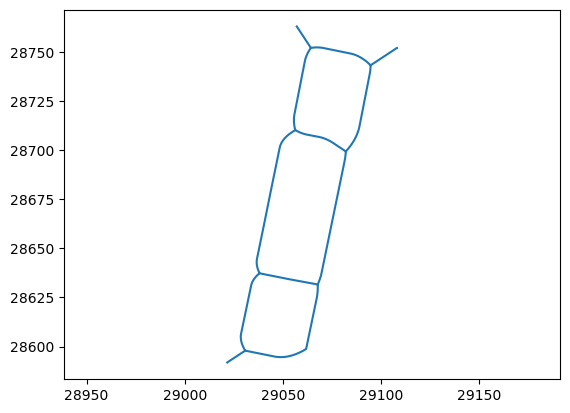

In [300]:
linestrings = []
for edge in G.edges:
    node0 = edge[0]
    node1 = edge[1]
    if G.degree(node0) <= 1 or G.degree(node1) <= 1:
        x0, y0, x1, y1 = None, None, None, None
        if G.degree(node0) <= 1:
            x0 = G.nodes[node1]['x']
            y0 = G.nodes[node1]['y']
            x1 = G.nodes[node0]['x']
            y1 = G.nodes[node0]['y']
        else:
            x0 = G.nodes[node0]['x']
            y0 = G.nodes[node0]['y']
            x1 = G.nodes[node1]['x']
            y1 = G.nodes[node1]['y']            
        length = distance([x0, y0], [x1, y1])
        x2 = (x1 - x0) / 5 + x0
        y2 = (y1 - y0) / 5 + y0
        extension = shapely.LineString([[x0, y0], [x2, y2]])
        if shapely.touches(extension, footprint.exterior) or shapely.intersects(extension, shapely.MultiLineString(footprint.interiors)):
            trimmed = shapely.intersection(extension, footprint)
            if isinstance(trimmed, shapely.LineString):
                linestrings.append(trimmed)
            else:
                linestrings.append(shapely.LineString([[x0, y0], [x1, y1]]))                
        else:
            linestrings.append(shapely.LineString([[x0, y0], [x1, y1]]))
    else:
        linestrings.append(shapely.LineString([[G.nodes[node0]['x'], G.nodes[node0]['y']], [G.nodes[node1]['x'], G.nodes[node1]['y']]]))
skeleton_extended = shapely.ops.linemerge(linestrings)
plot_linestrings(skeleton_extended)

Visualisation of building centreline with building footprint

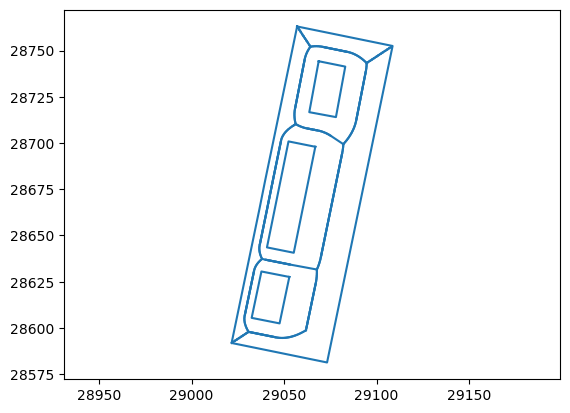

In [301]:
linestrings += [footprint.exterior] + [interior for interior in footprint.interiors]
plot_linestrings(shapely.MultiLineString(linestrings))